# Bach Chorales

## Imports

In [1]:
from IPython.utils import io
with io.capture_output() as captured:
  !pip install distrax
  !pip install numpyro

In [2]:
import jax

from jax import jit, lax, vmap
from jax.random import split, PRNGKey, permutation, normal
import jax.numpy as jnp
from jax.nn import log_softmax, sigmoid

import tensorflow as tf
import tensorflow_probability as tfp

import itertools


import distrax
from distrax import HMM

import numpy as np
import matplotlib.pyplot as plt

## Load Training Dataset

In [3]:
from numpyro.examples.datasets import JSB_CHORALES, load_dataset

_, fetch = load_dataset(JSB_CHORALES, split="train", shuffle=False)

lengths, sequences = fetch()

# find all the notes that are present at least once in the training set
present_notes = (sequences == 1).sum(0).sum(0) > 0
# remove notes that are never played (we remove 37/88 notes with default args)
sequences = sequences[..., present_notes]

## Gradient Descent

Creates mini-batches.

In [4]:
def hmm_sample_minibatches(iterables, batch_size):
    sequences, lens = iterables
    n_seq = len(sequences)
    for idx in range(0, n_seq, batch_size):
        yield sequences[idx:min(idx + batch_size, n_seq)], lens[idx:min(idx + batch_size, n_seq)]

In [5]:
def make_hmm(params):
    obs_logits, trans_logits = params
    trans_logits = log_softmax(trans_logits)

    obs_logits = jnp.clip(obs_logits, a_min=-12)
    trans_logits = jnp.clip(trans_logits, a_min=-12)

    b = distrax.Bernoulli(logits=obs_logits)
    obs_dist = distrax.Independent(b, 1)

    hmm = HMM(trans_dist= distrax.Categorical(logits=trans_logits),
                      obs_dist=obs_dist,
                      init_dist=distrax.Categorical(probs=initial_hmm.init_dist.probs))
    return hmm
  
@jit
def hmm_loglikelihood(hmm, observations, lens):
    def forward_(x, length):
      return hmm.forward(x, length)[0] / length
    return vmap(forward_, in_axes=(0, 0))(observations, lens)
    
@jit
def loss_fn(params, batch, lens):
    hmm = make_hmm(params)
    return -hmm_loglikelihood(hmm, batch, lens).mean()

@jit
def update(i, opt_state, batch, lens):
    params = get_params(opt_state)
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, lens)
    return opt_update(i, grads, opt_state), loss


def fit(observations, lens, beta, trans_dist,  batch_size, rng_key=None, num_epochs=300):
    if rng_key is None:
        rng_key = PRNGKey(0)

    opt_state = opt_init((beta.logits, trans_dist.logits))
    #opt_state = opt_init((logit(beta.probs), logit(trans_dist.probs)))
    itercount = itertools.count()

    num_complete_batches, leftover = jnp.divmod(num_epochs, batch_size)
    num_batches = num_complete_batches + jnp.where(leftover==0, 0, 1)

    def epoch_step(opt_state, key):
        perm = permutation(key, len(observations))
        observatios_, lens_= observations[perm], lens[perm]
        sample_generator = hmm_sample_minibatches((observatios_, lens_), batch_size)
        
        def train_step(opt_state, i):
            batch, length = next(sample_generator)
            opt_state, loss = update(next(itercount), opt_state, batch, length)
            return opt_state, loss

        opt_state, losses = jax.lax.scan(train_step, opt_state, jnp.arange(num_batches))
        return opt_state, losses.mean()

    epochs = split(rng_key, num_epochs)
    opt_state, losses = jax.lax.scan(epoch_step, opt_state, epochs)

    losses = losses.flatten()

    params = get_params(opt_state)
    hmm = make_hmm(params)
    obs_logits, _ = params
    return hmm, losses, obs_logits

## Initialize HMM

In [6]:
def init_hmm(K, D, initial_prob=0.1):
  trans_probs = distrax.as_distribution(tfp.substrates.jax.distributions.Dirichlet(0.9 * jnp.eye(K) + 0.1)).sample(seed=1)
  trans_dist = distrax.Categorical(probs=trans_probs)
  
  init_dist = distrax.Categorical(logits=jnp.zeros((K,)))
  
  b = distrax.Bernoulli(probs=jnp.full((K, D), initial_prob))
  obs_dist = distrax.Independent(b, 1)
  
  initial_hmm = HMM(trans_dist=trans_dist, obs_dist=obs_dist, init_dist=init_dist)
  return initial_hmm, b

In [7]:
K = 12
D = sequences.shape[2]
 
initial_hmm, b = init_hmm(K, D)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5792: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


## Determine Hyperparameters

In [8]:
num_epochs = 300 #@param {type:"slider", min:1, max:10000, step:0}
batch_size = 20 #@param {type:"slider", min:1, max:229, step:0}
learning_rate = 5e-2 #@param {type:"slider", min:0, max:1, step:0.01}

## Fit

In [9]:
opt_init, opt_update, get_params = jax.experimental.optimizers.adam(learning_rate)

hmm, losses, obs_logits = fit(sequences, lengths, b, initial_hmm.trans_dist, batch_size, num_epochs=num_epochs)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5792: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


## Loss Curve

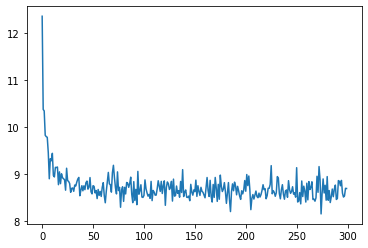

In [10]:
plt.plot(losses)
plt.show()

## Visualization of Parameters of HMM

### Observation Distribution

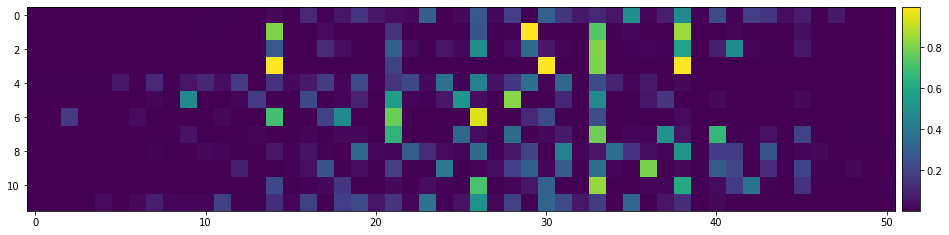

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(16, 16));
ax = plt.gca()
im = plt.imshow(sigmoid(obs_logits))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

plt.colorbar(im, cax=cax);

### Transition Probabilities

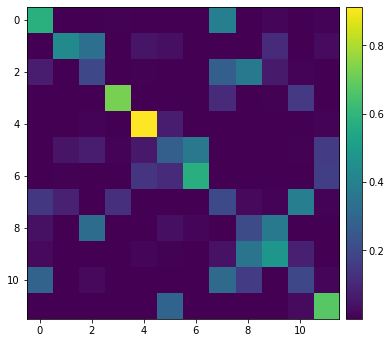

In [12]:
plt.figure(figsize=(6, 6));
ax = plt.gca()
im = plt.imshow(hmm.trans_dist.probs)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

plt.colorbar(im, cax=cax);

## Test

In [13]:
_, fetch = load_dataset(JSB_CHORALES, split="test", shuffle=False)

In [14]:
test_lengths, test_sequences = fetch()

# find all the notes that are present at least once in the training set
test_sequences = test_sequences[..., present_notes]

In [15]:
print('Test Negative Loglikelihood : ', -hmm_loglikelihood(hmm, test_sequences, test_lengths).mean()) # Test score

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5792: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


Test Negative Loglikelihood :  8.711813


## Loss Curves of the Different Number of Hidden States and Batch Sizes

In [16]:
hidden_states = [3, 9, 16, 25] # Used in the paper 
batch_sizes = [1, 20, 229]

D = test_sequences.shape[2]
num_epochs = 200

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5792: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5792: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5792: UserWarning

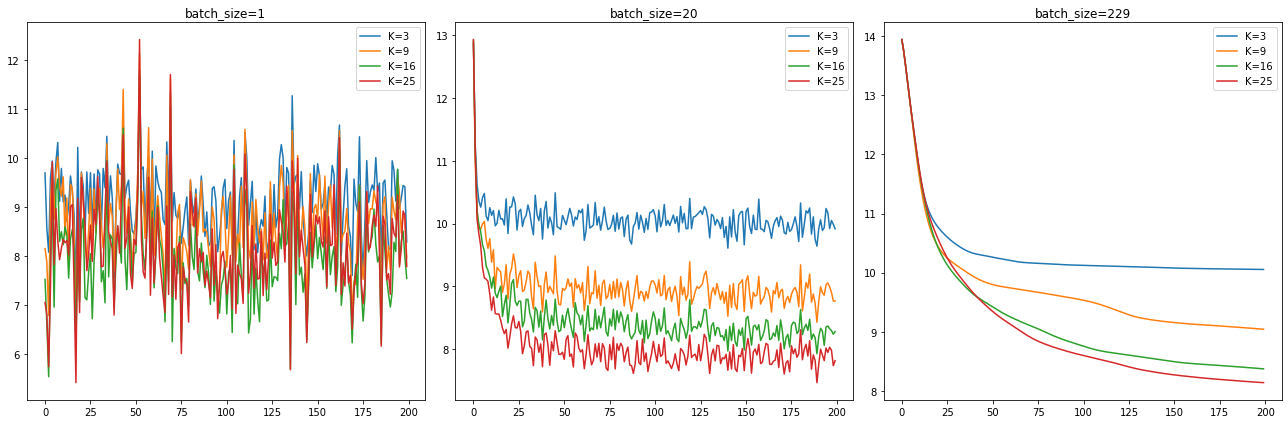

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=len(batch_sizes))
axes = np.array(axes)

fig.set_figheight(6)
fig.set_figwidth(18)

for batch_size, ax in zip(batch_sizes, axes.flatten()):
  for k in hidden_states:
    initial_hmm, b = init_hmm(k, D)
    _, loss, _ = fit(sequences, lengths, b, initial_hmm.trans_dist, batch_size, num_epochs=num_epochs)
    ax.plot(loss, label=f'K={k}')
    
  ax.set_title(f'batch_size={batch_size}')
  ax.legend(loc='upper right')

fig.tight_layout()
plt.show()